In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [39]:
from scipy.signal import medfilt as MF
from scipy.stats import scoreatpercentile as sap
from scipy.optimize import fmin, fmin_powell
from itertools import chain

%run ../src/core.py
%run ../src/lpf.py
%run ../extcore.py
%run -i lpf_broadband_dw.py

result_file_c = '../results/osiris'
run_name =  '/bb/vkwn_constrained'
seed(0)

N = lambda a: a/median(a)

In [40]:
%run ../src/lpf.py
%run -i lpf_broadband_dw.py
lpf = LPFC(noise='white', constant_k=False, use_ldtk=False)

In [41]:
de = DiffEvol(lpf.lnposterior, lpf.ps.bounds, 300, maximize=True, F=0.5, C=0.1)

for i,p in enumerate(lpf.ps.priors[0:4]):
    de._population[:,i] = normal(p.mean, p.std, size=de.n_pop)
    
for iq in chain(lpf.iq1,lpf.iq2):
    p = lpf.ps.priors[iq]
    de._population[:,iq] = normal(p.mean, 2*p.std, size=de.n_pop)
    
de._population[:,unique(lpf.ik2)] = uniform(0.165**2, 0.175**2, size=(de.n_pop, lpf.npb))

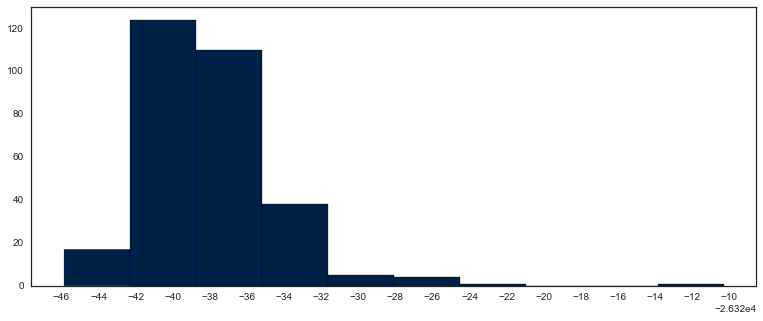

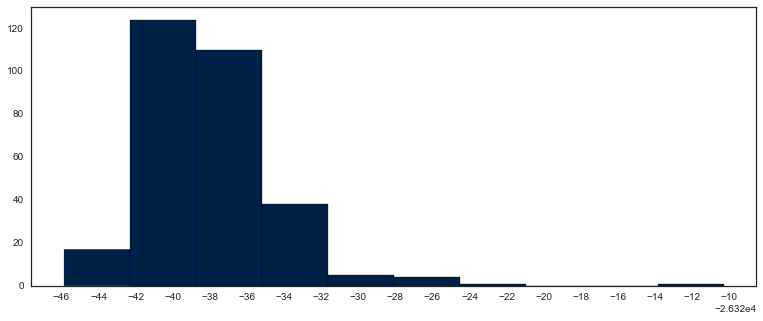

In [48]:
de.F = 0.25
de.C = 0.25
niter = 175
fig,ax = subplots(1,1)

try:
    for i,r in enumerate(de(niter)):
        if ((i+1)%10 == 0) or (i==niter-1):
            ax.cla()
            ax.hist(de._fitness)
            clear_output(wait=True)
            display(HTML('DE Iteration {:4d} max lnlike {:7.1f} med {:7.1f}'.format(i+1,-de.minimum_value,median(-de._fitness))))
            display(fig)
        if ((i+1)%5 == 0) and (i>120):
            for j in range(1):
                ipv = randint(0,high=de.n_pop)
                #pv = fmin(lambda pv: -lpf.lnposterior(pv), de.population[ipv], disp=True)
                #de._population[ipv,:] = pv
except KeyboardInterrupt:
    pass
finally:
    dfde = pd.DataFrame(de.population, columns=lpf.ps.names)
    dfde.to_hdf(result_file_c,'{:s}/de'.format(run_name))

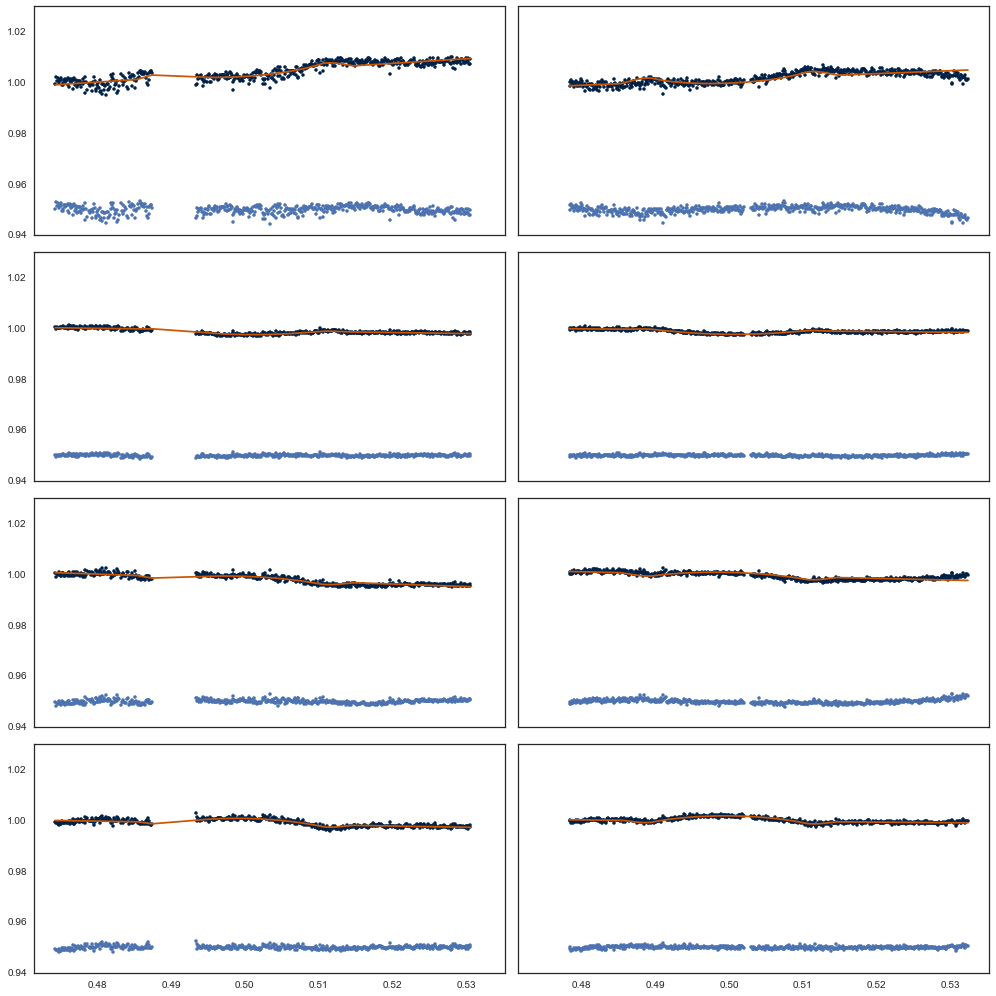

In [49]:
pv = de.minimum_location.copy()
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(4,2,figsize=(14,14), sharey=True, sharex=True)
for i in range(2):
    for j in range(4):
        ilc = 4*i+j
        phase = fold(lpf.times[ilc], pv[1], pv[0], 0.5)
        res = fos[ilc]-fms[ilc]
        axs[j,i].plot(phase, fos[ilc], '.')
        axs[j,i].plot(phase, fms[ilc])
        axs[j,i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.03))
fig.tight_layout()

In [50]:
sampler = EnsembleSampler(de.n_pop, de.n_par, lpf.lnposterior)

In [51]:
sampler.run_mcmc(de.population, 250);

In [99]:
sampler.run_mcmc(sampler.chain[:,-1,:], 1000);

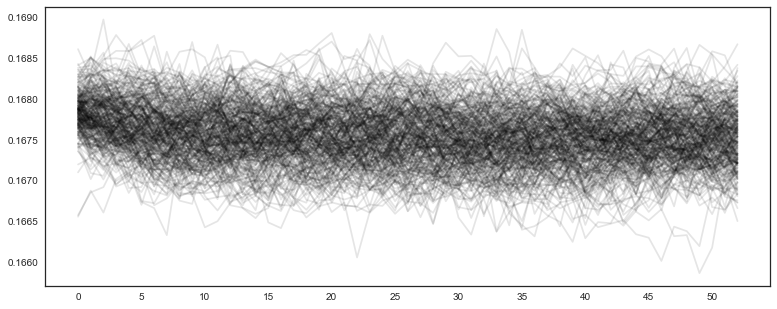

In [103]:
plot(sqrt(sampler.chain[:,0::100,4].T), 'k', alpha=0.1);

In [59]:
fc = pd.read_hdf(join('..',result_file), 'vkrn_ldtk/fc')

In [104]:
dff = pd.DataFrame(sampler.chain[:,1500::100,:].reshape([-1,lpf.ps.ndim]), columns=lpf.ps.names)

In [105]:
dff.to_hdf(result_file_c,'{:s}/fc_dw'.format(run_name))

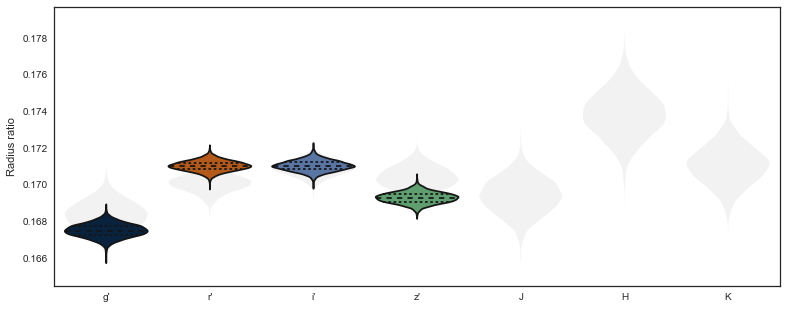

In [106]:
sb.violinplot(sqrt(fc['k2_g k2_r k2_i k2_z k2_J k2_H k2_K'.split()]), inner=None, color='0.95', linewidth=0, scale='width')
ax = sb.violinplot(sqrt(dff['k2_g k2_r k2_i k2_z'.split()]), inner='quartiles', scale='width')
setp(ax, xlim=(-0.5,6.5), xticks=arange(7), xticklabels="g' r' i' z' J H K".split(), ylabel='Radius ratio');

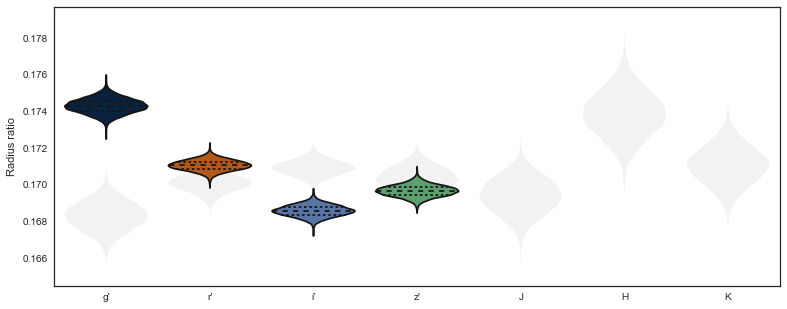

In [123]:
sb.violinplot(sqrt(fc['k2_g k2_r k2_i k2_z k2_J k2_H k2_K'.split()]), inner=None, color='0.95', linewidth=0, scale='width')
ax = sb.violinplot(sqrt(dff['k2_g k2_r k2_i k2_z'.split()]), inner='quartiles', scale='width')
setp(ax, xlim=(-0.5,6.5), xticks=arange(7), xticklabels="g' r' i' z' J H K".split(), ylabel='Radius ratio');

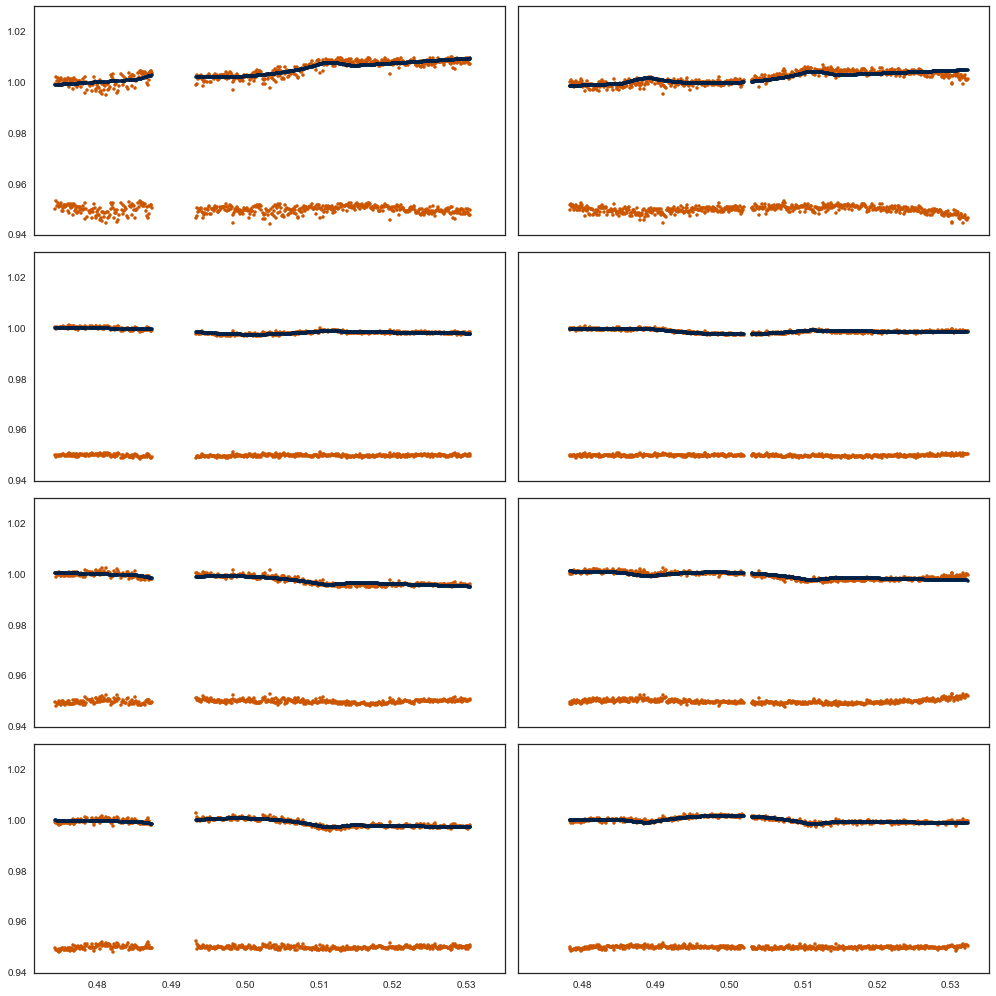

In [107]:
pv = median(dff.values, 0)
fms = lpf.compute_lc_model(pv)
fos = lpf.fluxes
fig,axs = subplots(4,2,figsize=(14,14), sharey=True, sharex=True)
for i in range(2):
    for j in range(4):
        ilc = 4*i+j
        phase = fold(lpf.times[ilc], pv[1], pv[0], 0.5)
        res = fos[ilc]-fms[ilc]
        axs[j,i].plot(phase, fos[ilc], '.', c=cp[1])
        axs[j,i].plot(phase, fms[ilc], '.')
        axs[j,i].plot(phase, res+0.95, '.')
setp(axs, ylim=(0.94,1.03))
fig.tight_layout()

(-0.01, 0.01)

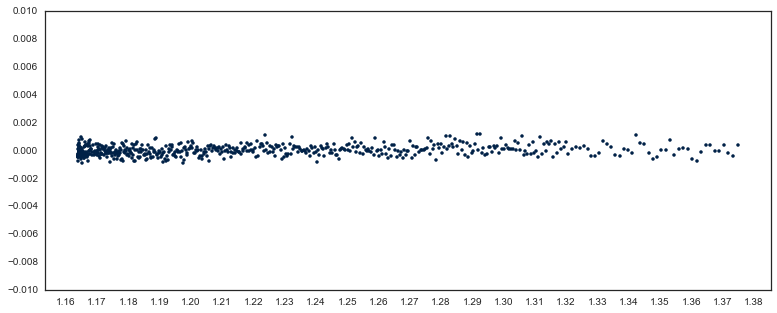

In [118]:
i = 5
plot(lpf.airmass[i], fos[i]-fms[i], '.')
ylim(-0.01,0.01)